In [1]:
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import describe
import datetime
from datetime import timedelta as timedelta
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import signal
import os, sys
sys.path.append( '/home/ugrads/c/clearloveyanzhen/CufflessBP/bioz_processing' )
import sicong_util as su
import sicong_duck_path as sp
import sicong_duck_path as sdp
plt.rcParams.update({'font.size': 13})
import seaborn as sns
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import random
import math

In [4]:
finapres_dict['A']

{'01': {'11_29_43': ['/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/finapres/test00-20210225 11_29_43.csv',
   '/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/finapres/test01-20210225 11_29_43.csv'],
  '12_01_21': ['/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/finapres/test00-20210225 12_01_21.csv',
   '/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/finapres/test01-20210225 12_01_21.csv'],
  '12_09_39': ['/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/finapres/test00-20210225 12_09_39.csv',
   '/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/finapres/test01-20210225 12_09_39.csv'],
  '12_25_01': ['/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/finapres/test00-20210225 12_25_01.csv',
   '/home/data/datasets/sicong_bioz_bp/75-1_75A/session01_0225-2021/finapres/test01-20210225 12_25_01.csv']},
 '02': {},
 '03': {'13_02_55': ['/home/data/datasets/sicong_bioz_bp/75-1_75A/

In [2]:
participant_dict, total_clean_beat = su.export_clean_beat_to_dict()
finapres_dict, total_finapres = su.export_finapres_to_dict()
su.test_subject = 'H'
fig_save_directory = '75H_intra-subject_plots/'
maneuver_time_list = [30, 210, 270]
label_dir={}
label_time = {}
label_index = {}
json_data = {}
for test_subject in su.subject_list[:7]:
# for test_subject in ['H', 'N']:
    su.test_subject = test_subject
    label_dir[su.test_subject] = {}
    label_time[su.test_subject] = {}
    label_index[su.test_subject] = {}
    json_data[su.test_subject] = {}
    for s in finapres_dict[su.test_subject]:
        if len(finapres_dict[su.test_subject][s]) != 0:
            label_dir[su.test_subject][s] = {}
            label_time[su.test_subject][s] = {}
            label_index[su.test_subject][s] = {}
            json_data[su.test_subject][s] = {}
            for trial in finapres_dict[su.test_subject][s]:
                # print(finapres_dict[su.test_subject][s][trial])
                data_all, clean_t, clean_i, labels, bioz_list, label_list = su.extract_trial(participant_dict[su.test_subject][s][trial], finapres_dict[su.test_subject][s][trial])
                labels_time_list = labels['new_Time'].tolist()
                label_i, label_t, y_true_sbp = su.match_labels(clean_t, bioz_list, labels_time_list, label_list, labels['reSYS'].tolist())
                label_i, label_t, y_true_dbp = su.match_labels(clean_t, bioz_list, labels_time_list, label_list, labels['reDIA'].tolist())
                labels = np.stack((y_true_sbp, y_true_dbp), axis=1)
                label_dir[su.test_subject][s][trial] = labels
                label_time[su.test_subject][s][trial] = label_t
                label_index[su.test_subject][s][trial] = label_i
                json_data[su.test_subject][s][trial] = data_all

In [3]:
def group_fpres(fprs_collection, group_num=3, sliding=True):
#     group_num is how many beats are grouped and taken average, sliding is whether it's a sliding window
    if group_num == 0:
        return fprs_collection
    out_collection = np.empty(fprs_collection.shape)
    for i in range(len(fprs_collection[:,1])-group_num):
        out_collection[i,0] = 0
        out_collection[i,1] = 0
        for j in range(group_num):
            out_collection[i,0] += fprs_collection[i+j,0]
            out_collection[i,1] += fprs_collection[i+j,1]            
        out_collection[i,0] /= group_num
        out_collection[i,1] /= group_num
    return out_collection

def clean_fprs(label_dir, group_num=0):
    cleaned_fprs_dict = {}
    for session in label_dir:
        if len(label_dir[session]) != 0:
            cleaned_fprs_dict[session] = {}
            for trial in label_dir[session]:
                val = label_dir[session][trial]
                val = val[val[:,0] != np.array([None])]
                val = val[val[:,0] <= np.array([220])]
                val = val[val[:,1] >= np.array([20])]
                val = group_fpres(val, group_num=group_num)
                val = val[val[:,0] <= np.array([220])]
                val = val[val[:,1] >= np.array([20])]
                cleaned_fprs_dict[session][subject] = val
    return cleaned_fprs_dict

def combine_all_fprs(label_dir):
    fprs_collection = np.empty((0,2))
    for session in label_dir:
        if len(label_dir[session]) != 0:
            for trial in label_dir[session]:
                val = label_dir[session][trial]
                val = val[val[:,0] != np.array([None])]
                val = val[val[:,0] <= np.array([220])]
                val = val[val[:,1] >= np.array([20])]
                val = group_fpres(val, group_num=10)
                val = val[val[:,0] <= np.array([220])]
                val = val[val[:,1] >= np.array([20])]
                fprs_collection = np.concatenate((fprs_collection,val), axis=0)
        # group_fpres(label_dir['01']['11_29_43'][:,0])
    return fprs_collection

In [4]:
# start of subject2subject
import warnings
warnings.filterwarnings("ignore")
sbp_stat_dict = {}
dbp_stat_dict = {}
tes_sbp = {}
tes_dbp = {}
sb = pd.DataFrame(columns=['subject', 'sbp', 'dbp'])
sb['sbp'] = sb['sbp'].astype('float')
sb['dbp'] = sb['dbp'].astype('float')
intervals_temp = [0,25,35,205,215,265,275,480,80,240]
tt = 99
min_size = 100000

sbp_session_stat_plot = []
dbp_session_stat_plot = []
person = 'H'
for person in label_dir:
    sbp_stat_dict[person] = {}
    dbp_stat_dict[person] = {}
    for i, session in enumerate(label_dir[person]):
        sbp_stat_dict[person][session] = {}
        dbp_stat_dict[person][session] = {}
        for j, trial in enumerate(label_dir[person][session]):
            if tt == 99:
                bp_interval= label_time[person][session][trial]>0
            else:
                bp_interval = (label_time[person][session][trial]>intervals_temp[tt]) & (label_time[person][session][trial]<=intervals_temp[tt+1])
            subset_index = []
            for k, e in enumerate(bp_interval):
                if e:
                    subset_index.append(k)
            if len(subset_index) > 1:
                bp_val = label_dir[person][session][trial][subset_index[0]:subset_index[-1],:]
                bp_val = bp_val[(bp_val[:,0] >= 80) & (bp_val[:,0] <= 200) & (bp_val[:,1] >= 40) & (bp_val[:,1] <= 120)]
            else:
                bp_val = np.array([[0,0],[0,0],[0,0]])
            cnm = '75'+person
            for lala, _ in enumerate(bp_val[:,0]):
                # sb = sb.append({'subject': cnm, 'sbp':bp_val[lala,0], 'dbp':bp_val[lala,1]}, ignore_index=True)
                sb = pd.concat([sb, pd.DataFrame({'subject': [cnm], 'sbp':[bp_val[lala,0]], 'dbp':[bp_val[lala,1]]})], ignore_index=True)
            min_size = min(min_size, len(bp_val[:,0]))
            tes_sbp[cnm] = bp_val[:,0].tolist()
            tes_dbp[cnm] = bp_val[:,1].tolist()
            # print(bp_val.shape)
            sbp_stat_dict[person][session][trial] = describe(bp_val[:,0])
            dbp_stat_dict[person][session][trial] = describe(bp_val[:,1])
    # print(sbp_stat_dict)
    # print()

In [5]:
# sb = sb[(sb['sbp'] >= 80)&(sb['sbp'] <= 220)&(sb['dbp'] >= 40)&(sb['dbp'] <= 130)]
# sb['sbp'] = sb['sbp'].astype('float')
# sb['dbp'] = sb['dbp'].astype('float')
# sb.dtypes


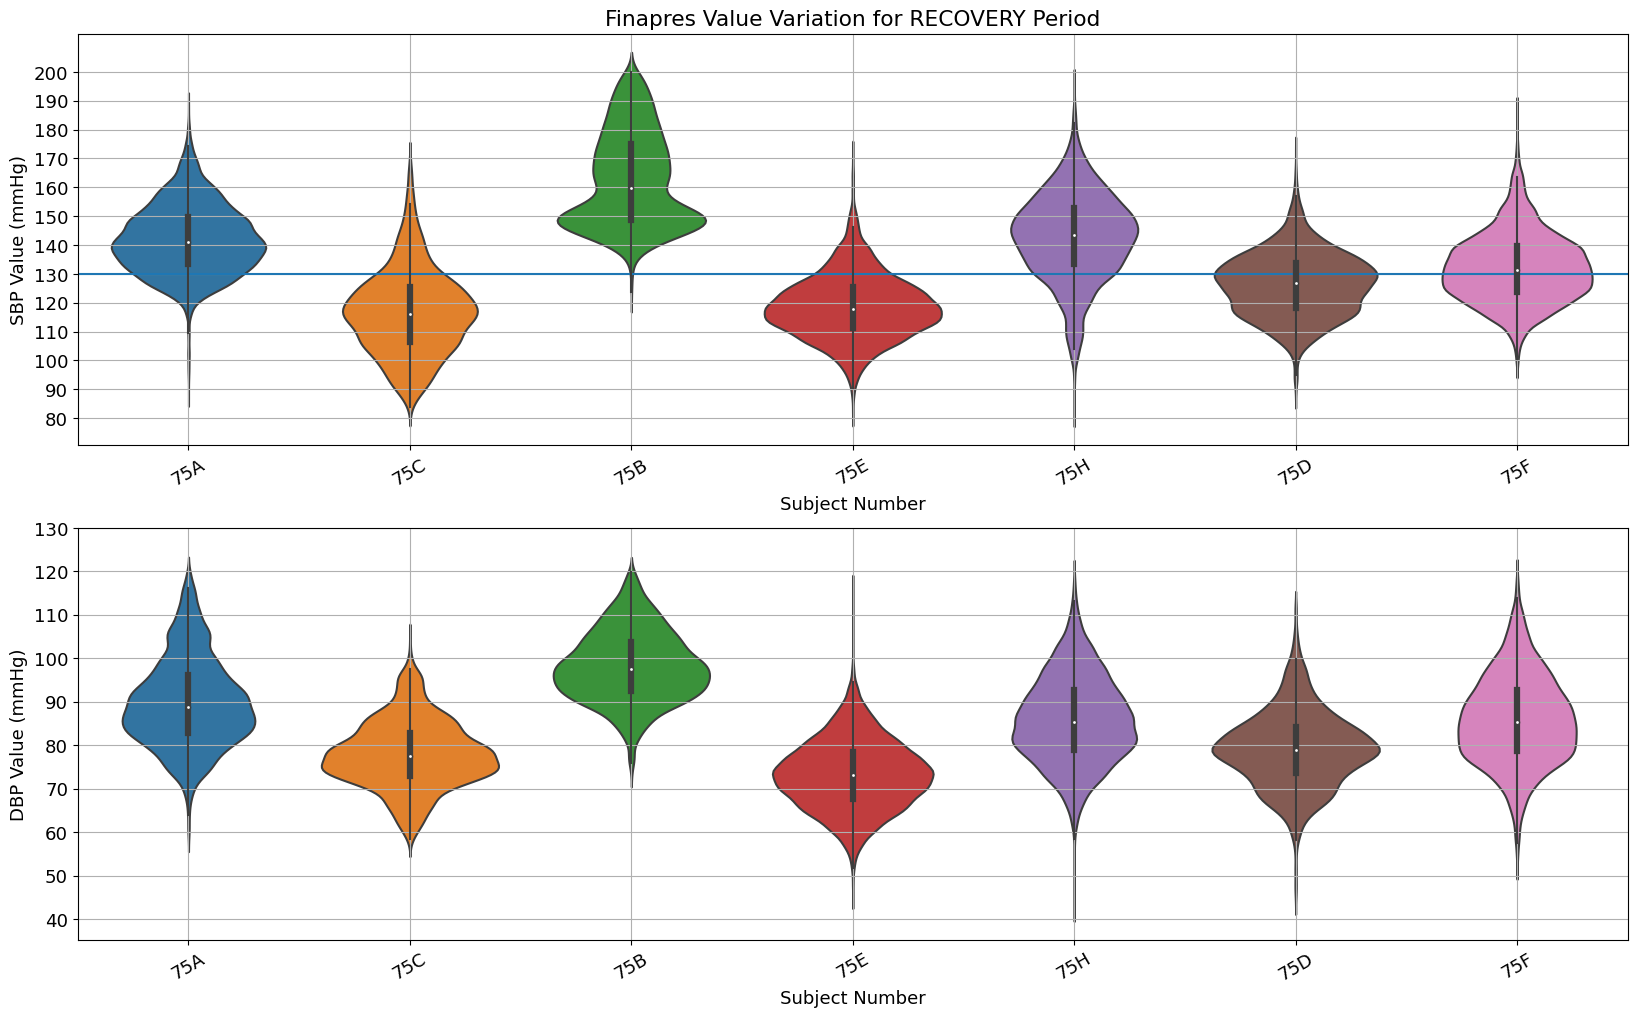

In [6]:
plt.figure(233, figsize=(20, 12), dpi=100)
plt.subplot(2,1,1)
plt.xticks(rotation=30)
plt.axhline(y=130)
plt.title('Finapres Value Variation for RECOVERY Period')
sns.violinplot(data=sb, x="subject", y="sbp")
plt.ylabel('SBP Value (mmHg)')
plt.xlabel('Subject Number')
plt.yticks(range(80, 210, 10))
plt.grid(visible=True)
plt.subplot(2,1,2)
plt.xticks(rotation=30)
sns.violinplot(x="subject", y="dbp", data=sb)
plt.ylabel('DBP Value (mmHg)')
plt.xlabel('Subject Number')
plt.yticks(range(40, 140, 10))
plt.grid(visible=True)

In [7]:
for each in label_dir:
    print(each, label_dir[each].keys())

A dict_keys(['01', '03', '04', '05', '06', '07'])
C dict_keys(['01'])
B dict_keys(['02', '04'])
E dict_keys(['01', '03', '04', '05', '06'])
H dict_keys(['01', '02', '03', '04', '05', '06', '07'])
D dict_keys(['03', '04', '06'])
F dict_keys(['01', '02', '03', '04', '05', '06'])


In [8]:
person_data = {}
person_channel={}
person_label = {}
def meet_seq(seq, goal=[130,130,130,130,130], length=3):
    return True
    for i in range(length):
        if seq.tolist().count(seq[i]) > 1:
            return False
        if abs(seq[i] - goal[i]) > 5:
            return False
    return True
for person in label_dir:
    person_data[person] = []
    person_channel[person] = []
    person_label[person] = []
    for session in label_dir[person]:
        for trial in label_dir[person][session]:
            sbp_labels = label_dir[person][session][trial][:,0]
            for i, each in enumerate(sbp_labels[:-3]):
                if meet_seq(sbp_labels[i:i+3]):
                    person_data[person].append(json_data[person][session][trial][i+2,:,0])
                    person_channel[person].append(json_data[person][session][trial][i+2,:,:])
                    person_label[person].append(1)

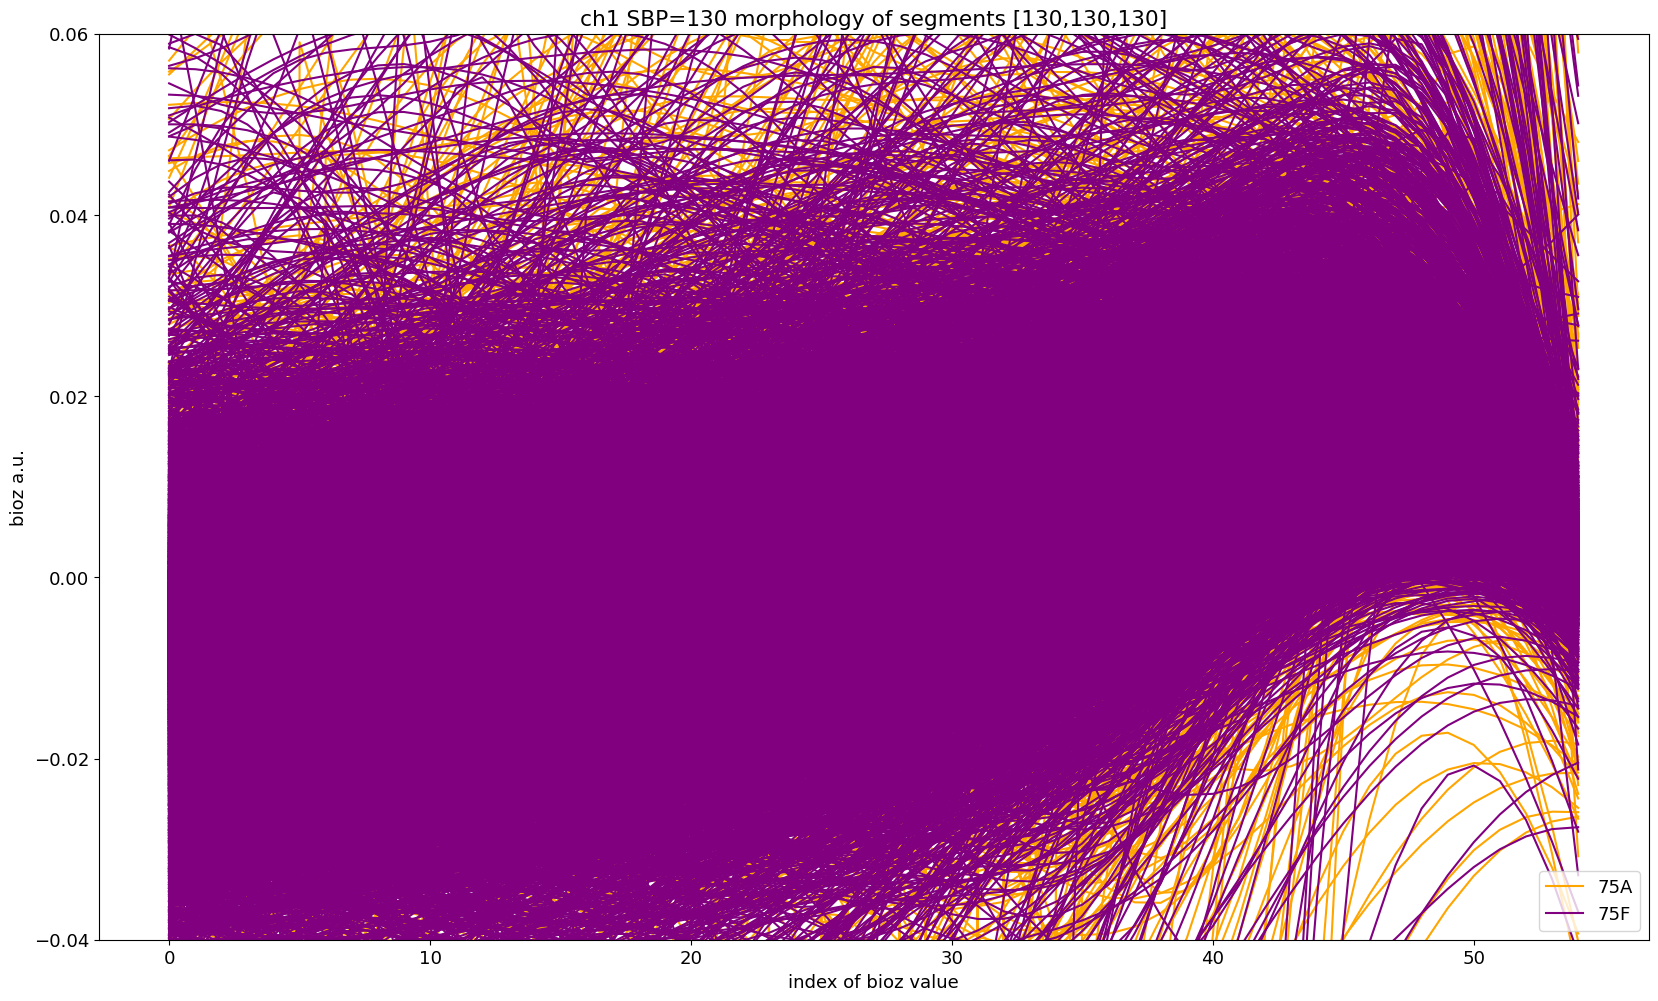

In [133]:
plt.figure(233, figsize=(20, 12), dpi=100)
plt.title('ch1 SBP=130 morphology of segments [130,130,130]')
plt.xlabel('index of bioz value')
plt.ylabel('bioz a.u.')
p1='A'
p2='F'
i=0
for each in person_data[p1]:
    # print(label_A[each], time_A[each], index_A[each])
    # temp_data = data_A[each,:,0]
    temp_data = each[-55:]
    # temp_data = temp_data[temp_data != -3]
    plt.plot(temp_data,color='orange', label='75'+p1 if i==0 else "")
    i += 1
i=0
for each in person_data[p2]:
    # print(label_E[each], time_E[each], index_E[each])
    # temp_data = data_E[each,:,0]
    temp_data = each[-55:]
    # temp_data = temp_data[temp_data != -3]
    # temp_data = temp_data[temp_data != 0]
    plt.plot(temp_data, color='purple', label='75'+p2 if i==0 else "")
    i+=1
plt.legend()
plt.ylim([-0.04, 0.06])
plt.show()

In [ ]:
# from fastdtw import fastdtw
# plt.figure(233, figsize=(20, 12), dpi=100)
# plt.title('avg DTW distance')
# plt.xlabel('line of A')
# plt.ylabel('avg DTW distance')
# plt.xlim([0,len(person_data[p1])])
# i=0
# overall_avg = {}
# disl = {}
# for p2 in ['A', 'E', 'D', 'F', 'H']:
#     if p2 != p1:
#         distance_list = []
#         for aa in person_data[p1]:
#             dis_temp = []
#             for ee in person_data[p2]:
#                 d, path = fastdtw(aa[-50:], ee[-50:], dist=distance.euclidean)
#                 dis_temp.append(d)
#             # plt.plot(dis_temp, label='75A' if i==0 else "")
#             distance_list.append(dis_temp)
#             i+=1
#         distance_list = np.array(distance_list)
#         plt.plot(np.mean(distance_list, axis=1), label=p1+'vs'+p2)
#         overall_avg[p2]=np.mean(distance_list, axis=None)
#         disl[p2]=np.mean(distance_list, axis=1)
# plt.legend()
for each in person_data:
    print(each, len(person_data[each]))

In [ ]:
# asd = pd.DataFrame(columns=['subject', 'dtw_distance'])
# for p in disl:
#     # plt.hist(disl[p],label='75'+p, alpha=0.3, bins=10)
#     for i in disl[p]:
#         asd=asd.append({'subject': p, 'dtw_distance to A':i}, ignore_index=True)
# sns.set(rc = {'figure.figsize':(20,12)})
# sns.displot(asd, x="dtw_distance to A", hue='subject', kind="kde")
# sns.set(rc = {'figure.figsize':(20,12)})

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader , TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [135]:
input_x = np.asarray(person_channel[p1])
test_x = np.asarray(person_channel[p2])
label_y = np.asarray(person_label[p1])
test_y = np.asarray(person_label[p2])
input_x = input_x.astype(np.float32)
test_x = test_x.astype(np.float32)
label_y = label_y.astype(np.float32)
test_y = test_y.astype(np.float32)
input_x = torch.tensor(input_x)
label_y = torch.tensor(label_y)
test_x = torch.tensor(test_x)
test_y = torch.tensor(test_y)
print(input_x.shape)
print(label_y.shape)
print(test_x.shape)
print(test_y.shape)

torch.Size([9436, 287, 4])
torch.Size([9436])
torch.Size([11611, 287, 4])
torch.Size([11611])


In [ ]:
# rnn = torch.nn.LSTM(input_size=4, hidden_size=20, num_layers=2, batch_first=True)
# h0 = torch.randn(2, 20, 20)
# c0 = torch.randn(2, 20, 20)
# output, (hn, cn) = rnn(input_x, (h0, c0))
# output.shape
# output = output.detach().numpy()

EMBEDDING_DIM = 4
HIDDEN_DIM = 20
SEQ_DIM=50
class LSTM_SH(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(LSTM_SH, self).__init__()
        self.hidden_dim=hidden_dim
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
    def forward(self, input_x):
        lstm_out, _ = self.lstm(input_x)
        score = F.relu(lstm_out)
        return score

In [ ]:
lstm_model = LSTM_SH(EMBEDDING_DIM, HIDDEN_DIM)
loss_func = nn.MSELoss()
optimizer = optim.SGD(lstm_model.parameters(), lr=0.1)
lstm_model.zero_grad()
with torch.no_grad():
    tag_score = lstm_model(input_x)
    print(tag_score[:,-SEQ_DIM:,:].shape)
    loss = loss_func(tag_score[:,-1,-1], label_y)
    print(loss)
loss_list = []
for epoch in range(50): # again, normally you would NOT do 300 epochs, it is toy data
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    lstm_model.zero_grad()

    # Step 3. Run our forward pass.
    tag_score = lstm_model(input_x)

    # Step 4. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_func(tag_score[:,-1,-1], label_y)
    loss_list.append(loss.detach().numpy())
    if epoch % 10 == 1:
        print(loss)
    loss.backward()
    optimizer.step()
    
# See what the scores are after training
with torch.no_grad():
    tag_score = lstm_model(input_x)
    print(tag_score[:,-SEQ_DIM:,:].shape)
    svm_input_p1= tag_score[:,-SEQ_DIM:,:].detach().numpy()
    loss = loss_func(tag_score[:,-1,-1], label_y)
    print(loss)

In [ ]:
plt.title('75A SBP==[130] loss curve')
plt.plot(loss_list)

In [136]:
with torch.no_grad():
    tag_score = lstm_model(test_x)
    print(tag_score[:,-50:,:].shape)
    svm_input_p2 = tag_score[:,-SEQ_DIM:,:].detach().numpy()
    loss = loss_func(tag_score[:,-1,-1], test_y)
    print(loss)

torch.Size([11611, 50, 20])
tensor(0.0300)


In [137]:
svm_label_p1 = np.zeros(len(svm_input_p1))
svm_label_p2 = np.ones(len(svm_input_p2))
svm_input_p1 = np.reshape(svm_input_p1, (len(svm_input_p1), SEQ_DIM * HIDDEN_DIM))
svm_input_p2 = np.reshape(svm_input_p2, (len(svm_input_p2), SEQ_DIM * HIDDEN_DIM))
print(svm_input_p1.shape, svm_input_p2.shape)
print(svm_label_p1.shape, svm_label_p2.shape)
c_val = 1000

(9436, 1000) (11611, 1000)
(9436,) (11611,)


In [138]:
mm = MinMaxScaler()
ss = StandardScaler()
X = np.concatenate((svm_input_p1, svm_input_p2), axis=0)
y = np.concatenate((svm_label_p1, svm_label_p2), axis=0)
X = mm.fit_transform(X)
from sklearn.utils import resample
X, y = resample(X, y)

In [139]:
from sklearn import svm
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lr = LogisticRegression(random_state=0, C=c_val)
xgb = xgboost.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
clf = svm.SVC(kernel='rbf', C=c_val)
models_used = {'lr':lr, 'xgb':xgb, 'svm': clf}
model_names = {'lr':'logistic regression', 'xgb':'XGBoost', 'svm': 'Support Vector Machine'}
colors_used = {'lr': 'orange', 'xgb': 'blue', 'svm': 'purple'}
scores = {}
for model in models_used:
    scores[model] = cross_val_score(models_used[model], X, y, cv=10, scoring='f1')

In [140]:
for model in models_used:
    models_used[model].fit(X_train, y_train)
    y_pred = models_used[model].predict(X_test)
    print(f1_score(y_test, y_pred))

0.8699722100336404
0.968931475029036
0.8943971839249046


Text(0.5, 1.0, 'Confusion Matrix with LSTM features with')

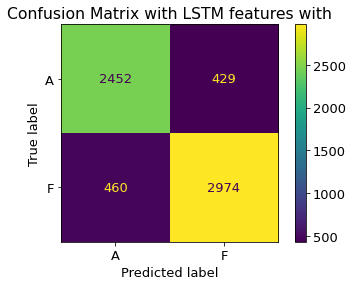

In [141]:
plot_confusion_matrix(models_used['lr'], X_test, y_test, display_labels=[p1, p2])
plt.title('Confusion Matrix with LSTM features with')

lr
0.8677736479981032
xgb
0.974760849774832
svm
0.9034435506428515


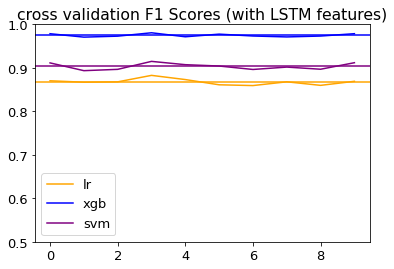

In [142]:
plt.title('cross validation F1 Scores (with LSTM features)')
for model in scores:
    plt.plot(scores[model], color=colors_used[model], label=model)
    plt.axhline(np.mean(scores[model]), color=colors_used[model])
    plt.ylim([0.5, 1])
    print(model)
    print(np.mean(scores[model]))
plt.legend()

In [143]:
input_x = np.asarray(person_channel[p1])
test_x = np.asarray(person_channel[p2])
label_y = np.asarray(person_label[p1])
test_y = np.asarray(person_label[p2])
label_y = np.zeros(len(label_y))
test_y = np.ones(len(test_y))
input_x = input_x[:,-SEQ_DIM:,:]
test_x = test_x[:,-SEQ_DIM:,:]
input_x = np.reshape(input_x, (len(input_x), 50 * 4))
test_x = np.reshape(test_x, (len(test_x), 50 * 4))
X = np.concatenate((input_x, test_x), axis=0)
y = np.concatenate((label_y, test_y), axis=0)
X =mm.fit_transform(X)
X, y = resample(X, y)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lr = LogisticRegression(random_state=0, C=c_val)
xgb = xgboost.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
clf = svm.SVC(kernel='rbf', C=c_val)
models_used = {'lr':lr, 'xgb':xgb, 'svm': clf}
model_names = {'lr':'logistic regression', 'xgb':'XGBoost', 'svm': 'Support Vector Machine'}
scores = {}
for model in models_used:
    scores[model] = cross_val_score(models_used[model], X, y, cv=10, scoring='f1')

In [145]:
for model in models_used:
    models_used[model].fit(X_train, y_train)
    y_pred = models_used[model].predict(X_test)
    print(f1_score(y_test, y_pred))

0.8645389027798205
0.971027216856892
0.8928359976317347


Text(0.5, 1.0, 'Confusion Matrix with raw features')

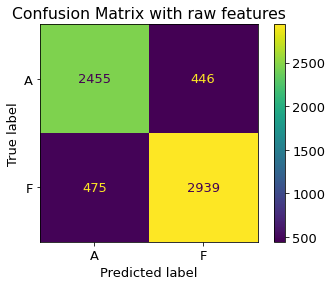

In [146]:
plot_confusion_matrix(models_used['lr'], X_test, y_test, display_labels=[p1, p2])
plt.title('Confusion Matrix with raw features')

lr
0.8658018646986243
xgb
0.9768238971723564
svm
0.8929269040429675


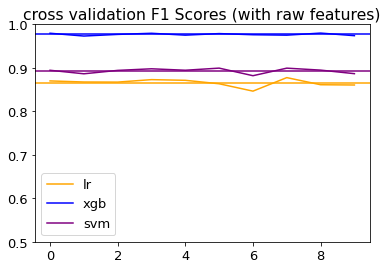

In [147]:
plt.title('cross validation F1 Scores (with raw features)')
for model in scores:
    plt.plot(scores[model], color=colors_used[model], label=model)
    plt.axhline(np.mean(scores[model]), color=colors_used[model])
    plt.ylim([0.5, 1])
    print(model)
    print(np.mean(scores[model]))
plt.legend()